In [30]:
import pandas as pd
import numpy as np
import itertools
import random
import ast
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, wilcoxon, friedmanchisquare, kendalltau, pearsonr
from matplotlib import animation
from mpl_toolkits import mplot3d
from scipy.spatial import distance
from pyxdameraulevenshtein import damerau_levenshtein_distance

pd.set_option('display.max_rows', 500)

### Prepare Data

In [55]:
# read data

df = pd.read_csv('all_task_environments_new.csv', header=0, skiprows=[1])

### Define functions for prediction

In [32]:
def predict_sequence(objects, coordinates, start_coordinates, c, k, dimension=[3,]):
    ''' Predicts sequence based on required objects, object coordinates, start coordinates of subject,
        parameters (c+k) and dimensionality.
        Input: Objects, object coordinates, start coordinates, c, k, dimension
        Output: Sequence of objects as str
    '''
    prediction = []
    possible_items = dict.fromkeys(objects, 0) # generate dict from object list
    coord_index = 0
    start_coords = start_coordinates
    coords = coordinates
    new_coords = {}
    new_start_coords = []
    
    if dimension[0] == 3: # no changes if 3D
        new_coords = coords
        new_start_coords = start_coords
        
    elif dimension[0] == 2: # 2D: remove obsolete coordinate
        if dimension[1] == 'xy':
            new_coords = {key: value[:-1] for key, value in coords.items()}
            new_start_coords = [x[:-1] for x in start_coords]
                
        elif dimension[1] == 'xz':
            new_start_coords = [[x[0], x[-1]] for x in start_coords]
            
            for key, value in coords.items():
                new_value = (value[0], value[-1])
                new_coords[key] = new_value
        
        elif dimension[1] == 'yz':
            new_coords = {key: value[1:] for key, value in coords.items()}
            new_start_coords = [x[1:] for x in start_coords]
                
    elif dimension[0] == 1: # 1D: choose appropriate coordinate
        if dimension[1] == 'x':
            new_coords = {key: value[0] for key, value in coords.items()}
            new_start_coords = [x[0] for x in start_coords]
        
        elif dimension[1] == 'y':
            new_coords = {key: value[1] for key, value in coords.items()}
            new_start_coords = [x[1] for x in start_coords]
        
        elif dimension[1] == 'z':
            new_coords = {key: value[2] for key, value in coords.items()}
            new_start_coords = [x[2] for x in start_coords]
    
    while bool(possible_items) == True: # while dict not empty
        for obj in possible_items.keys():
            possible_items[obj] = ((distance.euclidean(
                                new_start_coords[coord_index], 
                                new_coords[obj])
                                ) ** k[obj]) * c[obj]
        #print(possible_items)                      
        minval = min(possible_items.values())
        minval = [k for k, v in possible_items.items() if v == minval]
        minval = random.choice(minval) # choose prediction randomly if multiple items have same cost
        prediction.append(minval)
        del possible_items[minval]
        coord_index += 1
        
    return prediction

In [33]:
def get_average(objects, coordinates, start_coordinates, c, k, dimension, sequence):
    ''' Returns average edit distance (Damerau-Levenshtein) for 100 trials of sequence prediction.
    '''
    edit_list = []

    for x in range(0,100):
        result = ''.join(predict_sequence(objects, coordinates, start_coordinates, c, k, dimension))
        dl = damerau_levenshtein_distance(sequence,result)
        edit_list.append(dl)
    
    avg = np.mean(edit_list)
    return avg

In [34]:
def get_avg_editdist(data):
    ''' Calculates average edit distance for all combinations of parameters (c, k, dimension).
        Input: Dataframe with objects, coordinates, start coordinates, object categories
        Output: Dataframe with edit distance results (col name: parameters used)
    '''
    results = pd.DataFrame()
    dimensions = [[1,'x'],[1,'y'],[1,'z'],[2,'xy'],[2,'xz'],[2,'yz'],[3,'xyz']]
        
    for row in range(0,len(df)):
        objects = list(df.at[row,'objects'].split(','))
        strong_k = list(df.at[row,'strong_k'].split(','))
        mid_k = list(df.at[row,'mid_k'].split(','))
        coordinates = {key: ast.literal_eval(value) for key, value in (elem.split(': ') for elem in df.at[row,'coordinates'].split(';'))}
        start_coordinates = list(ast.literal_eval(df.at[row, 'start_coordinates']))
        sequence = str(df.at[row,'sequence'])
        
        #for k in np.arange(0.0,1.0,0.1):
        for k in np.arange(0,0.9,0.1):
            k_strong = round(k,2)
            k_mid = round(k + 0.1,2)
            k1 = {obj: k_strong if obj in strong_k else k_mid if obj in mid_k else 1.0 for obj in objects}
                    
            for c in np.arange(1.0,2.0,0.1):
                c = round(c, 1)
                c1 = {obj: c if obj in df.at[row, 'containment'] else 1.0 for obj in objects}
                
                for dim in dimensions:                
                    # get average edit distance
                    edit_dist = get_average(objects, coordinates, start_coordinates, c1, k1, dim, sequence)
                    edit_dist = edit_dist / len(sequence)
                    
                    params = 'c: ' + str(c) + '; k: ' + str(k_strong) + ',' + str(k_mid) + '; ' + str(dim[1])
                    results.at[row,params] = edit_dist
                    
    return results

### Calculate edit distances, create df

In [56]:
#%%timeit -n1 -r1
results_new = get_avg_editdist(df)

In [36]:
results_new

,"c: 1.0; k: 0.0,0.1; x","c: 1.0; k: 0.0,0.1; y","c: 1.0; k: 0.0,0.1; z","c: 1.0; k: 0.0,0.1; xy","c: 1.0; k: 0.0,0.1; xz","c: 1.0; k: 0.0,0.1; yz","c: 1.0; k: 0.0,0.1; xyz","c: 1.1; k: 0.0,0.1; x","c: 1.1; k: 0.0,0.1; y","c: 1.1; k: 0.0,0.1; z",...,"c: 1.8; k: 0.8,0.9; xz","c: 1.8; k: 0.8,0.9; yz","c: 1.8; k: 0.8,0.9; xyz","c: 1.9; k: 0.8,0.9; x","c: 1.9; k: 0.8,0.9; y","c: 1.9; k: 0.8,0.9; z","c: 1.9; k: 0.8,0.9; xy","c: 1.9; k: 0.8,0.9; xz","c: 1.9; k: 0.8,0.9; yz","c: 1.9; k: 0.8,0.9; xyz"
0,0.392000,0.862000,0.694000,0.310000,0.192000,0.400000,0.000000,0.190000,0.608000,0.720000,...,0.302000,0.400000,0.200000,0.212000,0.468000,0.482000,0.106000,0.306000,0.400000,0.200000
1,0.408000,0.600000,0.692000,0.200000,0.334000,0.600000,0.200000,0.194000,0.600000,0.694000,...,0.514000,0.600000,0.400000,0.208000,0.600000,0.524000,0.400000,0.508000,0.600000,0.400000
2,0.396000,0.600000,0.698000,0.000000,0.202000,0.600000,0.000000,0.200000,0.600000,0.698000,...,0.302000,0.400000,0.200000,0.198000,0.400000,0.410000,0.200000,0.298000,0.400000,0.200000
3,0.552000,0.400000,0.400000,0.200000,0.322000,0.400000,0.200000,0.396000,0.400000,0.400000,...,0.092000,0.200000,0.000000,0.402000,0.200000,0.264000,0.000000,0.098000,0.200000,0.000000
4,0.373333,0.666667,0.666667,0.513333,0.333333,0.666667,0.333333,0.000000,0.666667,0.333333,...,0.000000,0.480000,0.333333,0.000000,0.510000,0.166667,0.510000,0.000000,0.493333,0.333333
5,0.712000,0.472000,0.800000,0.616000,0.400000,0.302000,0.400000,0.690000,0.286000,0.800000,...,0.400000,0.800000,0.800000,0.626000,0.400000,0.800000,0.632000,0.400000,0.800000,0.800000
6,0.815000,0.720000,0.840000,1.000000,0.740000,1.000000,1.000000,0.785000,0.770000,0.755000,...,0.750000,0.500000,0.500000,0.760000,0.500000,0.735000,0.500000,0.765000,0.500000,0.500000
7,0.750000,1.000000,0.697500,1.000000,0.740000,1.000000,1.000000,1.000000,1.000000,0.705000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.690000,1.000000,1.000000,1.000000,1.000000
8,0.173333,0.280000,0.480000,0.000000,0.160000,0.340000,0.000000,0.143333,0.273333,0.470000,...,0.170000,0.306667,0.000000,0.150000,0.366667,0.453333,0.000000,0.160000,0.340000,0.000000
9,0.186667,0.513333,0.156667,0.333333,0.196667,0.333333,0.333333,0.170000,0.456667,0.150000,...,0.203333,0.333333,0.333333,0.170000,0.486667,0.170000,0.333333,0.166667,0.333333,0.333333


### Get lowest error, compare edit distances

In [37]:
def get_lowest_error(results):
    ''' Returns lowest error in dataframe and index of lowest error.
    '''
    for col in list(results):
        results.loc['mean',col] = results[col].mean()
        results.loc['median',col] = results[col].median()
    lowest = min(results.loc['mean'])
    mean = list(results.loc['mean'])
    
    return lowest, results.columns[(results.loc['mean'] == lowest)], mean, results

In [57]:
lowest, lowest_idx, list_mean, results_mean = get_lowest_error(results_new)
lowest, lowest_idx

(0.39967757936507936, Index(['c: 1.5; k: 0.2,0.3; xy'], dtype='object'))

In [58]:
mean_editdist = np.mean(list_mean)
median_editdist = np.median(results_mean.loc['median',:])
print(mean_editdist, median_editdist)

0.5095816368522718 0.5


In [59]:
# Compare avg edit distance for xy and xyz
list_xy = []
list_xyz = []
median_xy = []
median_xyz = []

for col in results_mean:
    if col.split(';')[2].strip() == 'xy':
        list_xy.append(results_mean.at['mean',col])
        median_xy.append(results_mean.at['median',col])
    elif col.split(';')[2].strip() == 'xyz':
        list_xyz.append(results_mean.at['mean',col])
        median_xyz.append(results_mean.at['median',col])
        
avg_xy = np.mean(list_xy)
med_xy = np.median(median_xy)
std_xy = np.std(list_xy)
print('Average xy: ' + str(avg_xy) + ', median: ' + str(med_xy)  + ', stdev: ' + str(std_xy))
        
avg_xyz = np.mean(list_xyz)
med_xyz = np.median(median_xyz)
std_xyz = np.std(list_xyz)
print('Average xyz: ' + str(avg_xyz) + ', median: ' + str(med_xyz) + ', stdev: ' + str(std_xyz))

Average xy: 0.43705972957084066, median: 0.4783333333333333, stdev: 0.014127795772818223
Average xyz: 0.4425648258377425, median: 0.4, stdev: 0.014502924037464088


In [16]:
# Compare avg edit distances for x, y, z
list_x = []
list_y = []
list_z = []
list_xz = []
list_yz = []

for col in results_mean:
    if col.split(';')[2].strip() == 'x':
        list_x.append(results_mean.at['mean',col])
    elif col.split(';')[2].strip() == 'y':
        list_y.append(results_mean.at['mean',col])
    elif col.split(';')[2].strip() == 'z':
        list_z.append(results_mean.at['mean',col])
    elif col.split(';')[2].strip() == 'xz':
        list_xz.append(results_mean.at['mean',col])
    elif col.split(';')[2].strip() == 'yz':
        list_yz.append(results_mean.at['mean',col])

avg_xz = np.mean(list_xz)
avg_yz = np.mean(list_yz)
        
avg_x = np.mean(list_x)
lowest_x = min(list_x)
print('Average x: ' + str(avg_x) + ', min: ' + str(lowest_x)) 
        
avg_y = np.mean(list_y)
lowest_y = min(list_y)
print('Average y: ' + str(avg_y) + ', min: ' + str(lowest_y)) 
        
avg_z = np.mean(list_z)
lowest_z = min(list_z)
print('Average z: ' + str(avg_z) + ', min: ' + str(lowest_z)) 

print('Average xz: ' + str(avg_xz)) 
print('Average yz: ' + str(avg_yz)) 

Average x: 0.5007691909171076, min: 0.48830787037037043
Average y: 0.5321137088477366, min: 0.5027367724867725
Average z: 0.5936261721046444, min: 0.5709017857142858
Average xz: 0.5081482032627868
Average yz: 0.5312982179600235


### Statistical analysis

In [18]:
# correlate avg edit distance with volume of environment space

dimensions_error = [avg_x, avg_y, avg_z, avg_xy, avg_xz, avg_yz, avg_xyz]
dimensions_volume = [1.889,3.1667,1.8333,6.5556,3.5,6.0556,12.5556]
dimensions_volume_corr = [1.889,3.1667,1.8333,6.5556,3.5,6.0556,19.1111]
#volumes_z 

corr, p = spearmanr(dimensions_error, dimensions_volume)
print('Spearman dims: \u03C1 = %.3f, p = %.15f' % (corr, p))

means = list(results_mean.loc['mean',:])
dimensions_vol = dimensions_volume * 90
dimensions_vol_corr = dimensions_volume_corr * 90

corr, p = spearmanr(means, dimensions_vol)
print('Spearman dims: \u03C1 = %.3f, p = %.20f' % (corr, p))

corr, p = spearmanr(means, dimensions_vol_corr)
print('Spearman dims corrected: \u03C1 = %.3f, p = %.20f' % (corr, p))

Spearman dims: ρ = -0.714, p = 0.071343561467538
Spearman dims: ρ = -0.708, p = 0.00000000000000000000
Spearman dims corrected: ρ = -0.708, p = 0.00000000000000000000


In [22]:
# Compare all error predictions for dimensions
stat, p = friedmanchisquare(list_x,list_y,list_z,list_xy,list_xz,list_yz,list_xyz)
print('Friedman: stat = %.3f, p = % 10.3E' % (stat, p))

Friedman: stat = 511.486, p =  2.820E-107


In [111]:
# compare individual dimensions (error predictions)

# 2D
print('2D:')
corr, p = spearmanr(list_x, list_xy)
print('Spearman x: \u03C1 = %.3f, p = %.15f' % (corr, p))

corr, p = spearmanr(list_y, list_xy)
print('Spearman y: \u03C1 = %.3f, p = %.15f' % (corr, p))

corr, p = kendalltau(list_y, list_xy)
print('Kendall: \u03C4 b = %.3f, p = %.15f' % (corr, p))

# 3D
print('3D:')
corr, p = spearmanr(list_x, list_xyz)
print('Spearman x: \u03C1 = %.3f, p = %.15f' % (corr, p))

corr, p = spearmanr(list_y, list_xyz)
print('Spearman y: \u03C1 = %.3f, p = %.15f' % (corr, p))

corr, p = spearmanr(list_z, list_xy)
print('Spearman z: \u03C1 = %.3f, p = %.15f' % (corr, p))

# 2D vs 3D
print('2D vs 3D:')
stat, p = wilcoxon(list_xy, list_xyz, zero_method='wilcox')
print('Wilcoxon: W = %.3f, p = %.3f' % (stat, p))

stat, p = wilcoxon(list_xy, list_xyz, zero_method='wilcox', alternative='less')
print('Wilcoxon: W = %.3f, p = %.3f' % (stat, p))

2D:
Spearman x: ρ = 0.127, p = 0.232560116661718
Spearman y: ρ = 0.448, p = 0.000009421421155
Kendall: τ b = 0.300, p = 0.000028417958911
3D:
Spearman x: ρ = -0.330, p = 0.001497799655866
Spearman y: ρ = -0.036, p = 0.737992071913454
Spearman z: ρ = 0.462, p = 0.000004537140209
2D vs 3D:
Wilcoxon: W = 1302.000, p = 0.003
Wilcoxon: W = 1302.000, p = 0.001


In [51]:
# 2D vs 3D median
print('2D vs 3D medians:')
stat, p = wilcoxon(median_xy, median_xyz, zero_method='wilcox')
print('Wilcoxon: W = %.3f, p = %.3f' % (stat, p))

2D vs 3D medians:
Wilcoxon: W = 14.000, p = 0.000


### Prepare data + plots

In [19]:
# prepare data for plots

means_x, means_y, means_z, means_xy, means_xz, means_yz, means_xyz = ([] for i in range(7))

for i in range(0,len(means),7):
    means_x.append(means[i])
    means_y.append(means[i+1])
    means_z.append(means[i+2])
    means_xy.append(means[i+3])
    means_xz.append(means[i+4])
    means_yz.append(means[i+5])
    means_xyz.append(means[i+6])
    
dim_x = []
dim_x.append(dimensions_volume[0])
dim_x = dim_x * 90

dim_y = []
dim_y.append(dimensions_volume[1])
dim_y = dim_y * 90

dim_z = []
dim_z.append(dimensions_volume[2])
dim_z = dim_z * 90

dim_xy = []
dim_xy.append(dimensions_volume[3])
dim_xy = dim_xy * 90

dim_xz = []
dim_xz.append(dimensions_volume[4])
dim_xz = dim_xz * 90

dim_yz = []
dim_yz.append(dimensions_volume[5])
dim_yz = dim_yz * 90

dim_xyz = []
dim_xyz.append(dimensions_volume[6])
dim_xyz = dim_xyz * 90

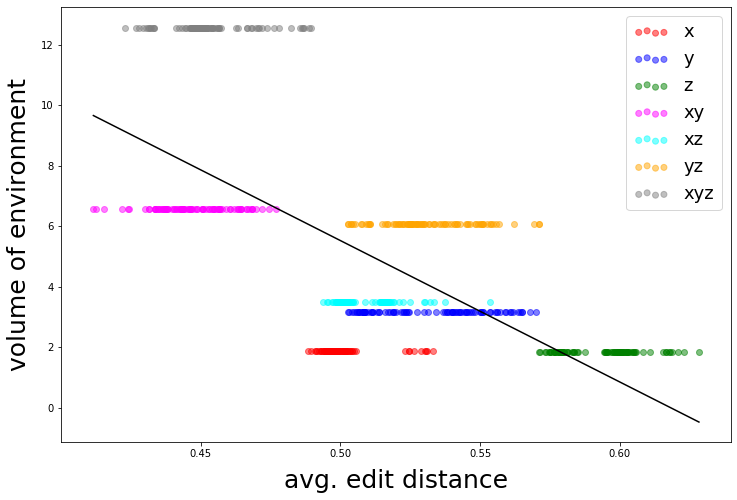

In [20]:
# plot error rate for all dims depending on volume

cm = ['red','blue','green','magenta','cyan','orange','grey']

fig = plt.figure(figsize=(12,8))
plot_x = plt.scatter(means_x, dim_x, alpha=0.5, c=cm[0], label='x')
plot_y = plt.scatter(means_y, dim_y, alpha=0.5, c=cm[1], label='y')
plot_z = plt.scatter(means_z, dim_z, alpha=0.5, c=cm[2], label='z')
plot_xy = plt.scatter(means_xy, dim_xy, alpha=0.5, c=cm[3], label='xy')
plot_xz = plt.scatter(means_xz, dim_xz, alpha=0.5, c=cm[4], label='xz')
plot_yz = plt.scatter(means_yz, dim_yz, alpha=0.5, c=cm[5], label='yz')
plot_xyz = plt.scatter(means_xyz, dim_xyz, alpha=0.5, c=cm[6], label='xyz')

plt.plot(np.unique(means), np.poly1d(np.polyfit(means, dimensions_vol, 1))(np.unique(means)), color='black')
plt.ylabel('volume of environment', fontsize=25, labelpad=10)
plt.xlabel('avg. edit distance', fontsize=25, labelpad=10)

# create legend
plt.legend(scatterpoints=4, fontsize=18)

plt.show()

In [21]:
# get individual points for correlation plot
editdist_x, editdist_y, editdist_z, editdist_xy, editdist_xz, editdist_yz, editdist_xyz = ([] for i in range(7))

for col in results_mean:
    if col.split(';')[2].strip() == 'x':
        editdist_x.append(list(results_mean[col].iloc[:-1]))
    elif col.split(';')[2].strip() == 'y':
        editdist_y.append(list(results_mean[col].iloc[:-1]))
    elif col.split(';')[2].strip() == 'z':
        editdist_z.append(list(results_mean[col].iloc[:-1]))
    elif col.split(';')[2].strip() == 'xy':
        editdist_xy.append(list(results_mean[col].iloc[:-1]))
    elif col.split(';')[2].strip() == 'xz':
        editdist_xz.append(list(results_mean[col].iloc[:-1]))
    elif col.split(';')[2].strip() == 'yz':
        editdist_yz.append(list(results_mean[col].iloc[:-1]))
    elif col.split(';')[2].strip() == 'xyz':
        editdist_xyz.append(list(results_mean[col].iloc[:-1]))
        
editdist_x = [item for sublist in editdist_x for item in sublist]
editdist_y = [item for sublist in editdist_y for item in sublist]
editdist_z = [item for sublist in editdist_z for item in sublist]
editdist_xy = [item for sublist in editdist_xy for item in sublist]
editdist_xz = [item for sublist in editdist_xz for item in sublist]
editdist_yz = [item for sublist in editdist_yz for item in sublist]
editdist_xyz = [item for sublist in editdist_xyz for item in sublist]

volumes_x = [3,3,3,3,2,4,2,4,1,2,2,2,2,2,1,1,1,1,1,1,2,2,2,2]
volumes_y = [3,3,3,3,3,5,4,5,2,3,3,3,3,4,2,3,3,3,3,3,2,2,2,2]
volumes_z = [2,2,2,2,2,2,2,2,0,2,3,1,1,2,1,3,3,0,3,3,1,1,1,1]
volumes_xy = [9,9,9,9,6,20,8,20,2,6,6,6,6,8,2,3,3,3,3,3,4,4,4,4]
volumes_xz = [6,6,6,6,4,8,4,8,1,4,6,2,2,4,1,3,3,1,3,3,2,2,2,2]
volumes_yz = [6,6,6,6,6,10,8,10,2,6,9,3,3,8,2,9,9,3,9,9,2,2,2,2]
volumes_xyz = [18,18,18,18,12,40,16,40,2,12,18,6,6,16,2,9,9,3,9,9,4,4,4,4]

volumes_x = volumes_x * 90
volumes_y = volumes_y * 90
volumes_z = volumes_z * 90
volumes_xy = volumes_xy * 90
volumes_xz = volumes_xz * 90
volumes_yz = volumes_yz * 90
volumes_xyz = volumes_xyz * 90

ValueError: x and y must be the same size

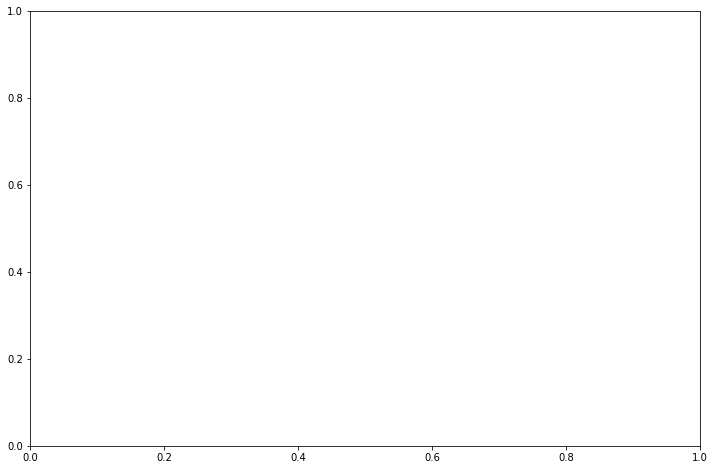

In [22]:
# plot error rate for individual values

cm = ['red','blue','green','magenta','cyan','orange','grey']

fig = plt.figure(figsize=(12,8))
plot_x = plt.scatter(editdist_x, volumes_x, alpha=0.5, c=cm[0], label='x')
plot_y = plt.scatter(editdist_y, volumes_y, alpha=0.5, c=cm[1], label='y')
plot_z = plt.scatter(editdist_z, volumes_z, alpha=0.5, c=cm[2], label='z')
plot_xy = plt.scatter(editdist_xy, volumes_xy, alpha=0.5, c=cm[3], label='xy')
plot_xz = plt.scatter(editdist_xz, volumes_xz, alpha=0.5, c=cm[4], label='xz')
plot_yz = plt.scatter(editdist_yz, volumes_yz, alpha=0.5, c=cm[5], label='yz')
plot_xyz = plt.scatter(editdist_xyz, volumes_xyz, alpha=0.5, c=cm[6], label='xyz')

plt.plot(np.unique(means), np.poly1d(np.polyfit(means, dimensions_vol, 1))(np.unique(means)), color='black')
plt.ylabel('volume of environment', fontsize=25, labelpad=10)
plt.xlabel('avg. edit distance', fontsize=25, labelpad=10)

# create legend
plt.legend(scatterpoints=4, fontsize=18)

plt.show()

### Plots for dataframe

In [23]:
# Define input for plots

c = [float(x[3:6]) for x in results_new.columns.tolist()]
k = [float(x[11:14]) for x in results_new.columns.tolist()]
dim = [x.strip() for x in results_new.columns.str.split(';').str[2]]
error = results_mean.loc['mean'].tolist()
median = results_mean.loc['median'].tolist()

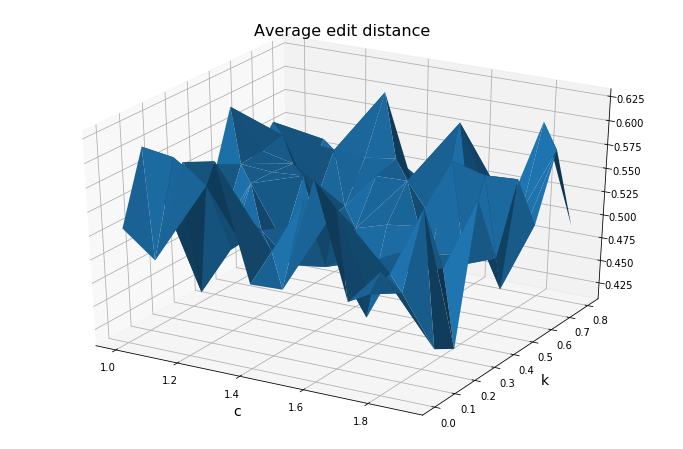

In [24]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')

ax.plot_trisurf(c, k, error, linewidth=0.2)
ax.set_ylabel('k', fontsize=14, labelpad=7)
ax.set_xlabel('c', fontsize=14, labelpad=7)
plt.title('Average edit distance', fontsize=16)
plt.show()

In [29]:
%matplotlib qt

cm = ['red','blue','green','magenta','cyan','orange','grey']
dim_num = [0 if x=='x' else 1 if x=='y' else 2 if x=='z' else 3 if x=='xy' else 4 if x=='xz' else 5 if x=='yz' else 6 for x in dim]

cmap = matplotlib.colors.ListedColormap(cm)

ticks = ['x', 'y', 'z', 'xy', 'xz', 'yz', 'xyz']
norm = matplotlib.colors.BoundaryNorm(ticks, cmap.N)

# create figure, 3d grid, set background to white
fig2 = plt.figure(figsize=(12,8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.w_xaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax2.w_yaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax2.w_zaxis.set_pane_color((1.0,1.0,1.0,1.0))

# create plot w/ median edit distance
img = ax2.scatter(c, k, median, alpha=0.5, s=38, c=dim_num, cmap=cmap)

# plot horizontal plane for baseline
xx, yy = np.meshgrid(np.linspace(1,1.9), np.linspace(0,0.9))
#yy = np.meshgrid(range(2), range(2))
zz = xx * 0 + 0.603
ax2.plot_surface(xx, yy, zz, alpha=0.5)

# set labels
ax2.set_ylabel('parameter k', fontsize=20, labelpad=10)
ax2.set_xlabel('parameter c', fontsize=20, labelpad=10)
ax2.set_zlabel('edit distance median', fontsize=20, labelpad=7)
#plt.title('Average edit distance (1 step)', fontsize=24)

# create colorbar
cb = plt.colorbar(img, cax = fig2.add_axes([0.9,0.3,0.03,0.4]))
cb.ax.set_yticklabels(ticks, fontsize=16)
plt.show()

In [15]:
# generate rotating image

fig3 = plt.figure(figsize=(12,8))
ax3 = mplot3d.Axes3D(fig3)
ax3.w_xaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax3.w_yaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax3.w_zaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax3.set_ylabel('parameter k', fontsize=14, labelpad=7)
ax3.set_xlabel('parameter c', fontsize=14, labelpad=7)
ax3.set_zlabel('normalized edit distance', fontsize=14, labelpad=7)

def init():
    ax3.scatter(c, k, error, alpha=0.5, s=38, c=dim_num, cmap=cmap)
    
    return fig,

def animate(i):
    ax3.view_init(elev=10, azim=i*4)
    return fig,

animated = animation.FuncAnimation(fig3, animate, init_func=init, frames=90, interval=50, blit=True)

In [284]:
# save animated fig

plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

fig_name = 'rotate_model_lowesterror_3D'
#animated.save(fig_name+'.gif', writer='imagemagick', fps=1000/50)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, bitrate=10000)
animated.save(fig_name+'.mp4', writer=writer)